### Import modules and packages. define functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import pims
from scipy import stats

%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

plt.rcParams.update({'font.size': 22})


### Specify experiment directory, condtions and image details
#### Makes dictionary for GluR1r storage of results

In [2]:
expdir='/Users/taldankovich/Documents/LTPSlices/' #master folder

condition1_dir='/Users/taldankovich/Documents/LTPSlices/Ctrl/'
condition1_name='Ctrl'
condition2_dir='/Users/taldankovich/Documents/LTPSlices/LTP/'
condition2_name='LTP'
#condition3_dir='/Users/taldankovich/Documents/expanydays/4days/'
#condition3_name'2 days'
#condition4_dir='/Users/taldankovich/Documents/expanydays/2days/'
#condition4_name='2 days + bic'

ECM_channel_no=1 #channel number of GluR1 incubation colour
GluR1_channel_no=2 #channel number of ECM incubation colour

results = {"filename":[],
           "Slice_id":[],
           "ECM colour - spots mask":[],
           "GluR1 colour - spots mask":[],
           "exp condition":[],
           "ECM colour - Raw mean intensity":[],
           "GluR1 colour - Raw mean intensity":[],
           "Mean correlation coefficient ECM/GluR1":[],
           "ECM colour - Mean intensity of spots":[], #based on spot segmentation mask
           "GluR1 colour - Mean intensity of spots":[], #based on spot segmentation mask
           "ECM colour - Total no. of spots in FOV":[],
           "GluR1 colour - Total no. of spots in FOV":[],
           "ECM colour - Mean spot area [nm]":[],
           "GluR1 colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (ECM=-1<x<1=GluR1)":[],
           "ECM colour - Mean intensity, masked by GluR1 spots":[],
           "ECM colour - Mean intensity, outside of GluR1 spots":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif"):
        results["filename"].append(filelist[i])
        head, sep, tail = filelist[i].partition('_60x_')
        results["Slice_id"].append(head)
        if filelist[i].startswith(condition1_dir):
            results["exp condition"].append(condition1_name)
        elif filelist[i].startswith(condition2_dir):
            results["exp condition"].append(condition2_name)
        else:
            results["exp condition"].append('other')

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


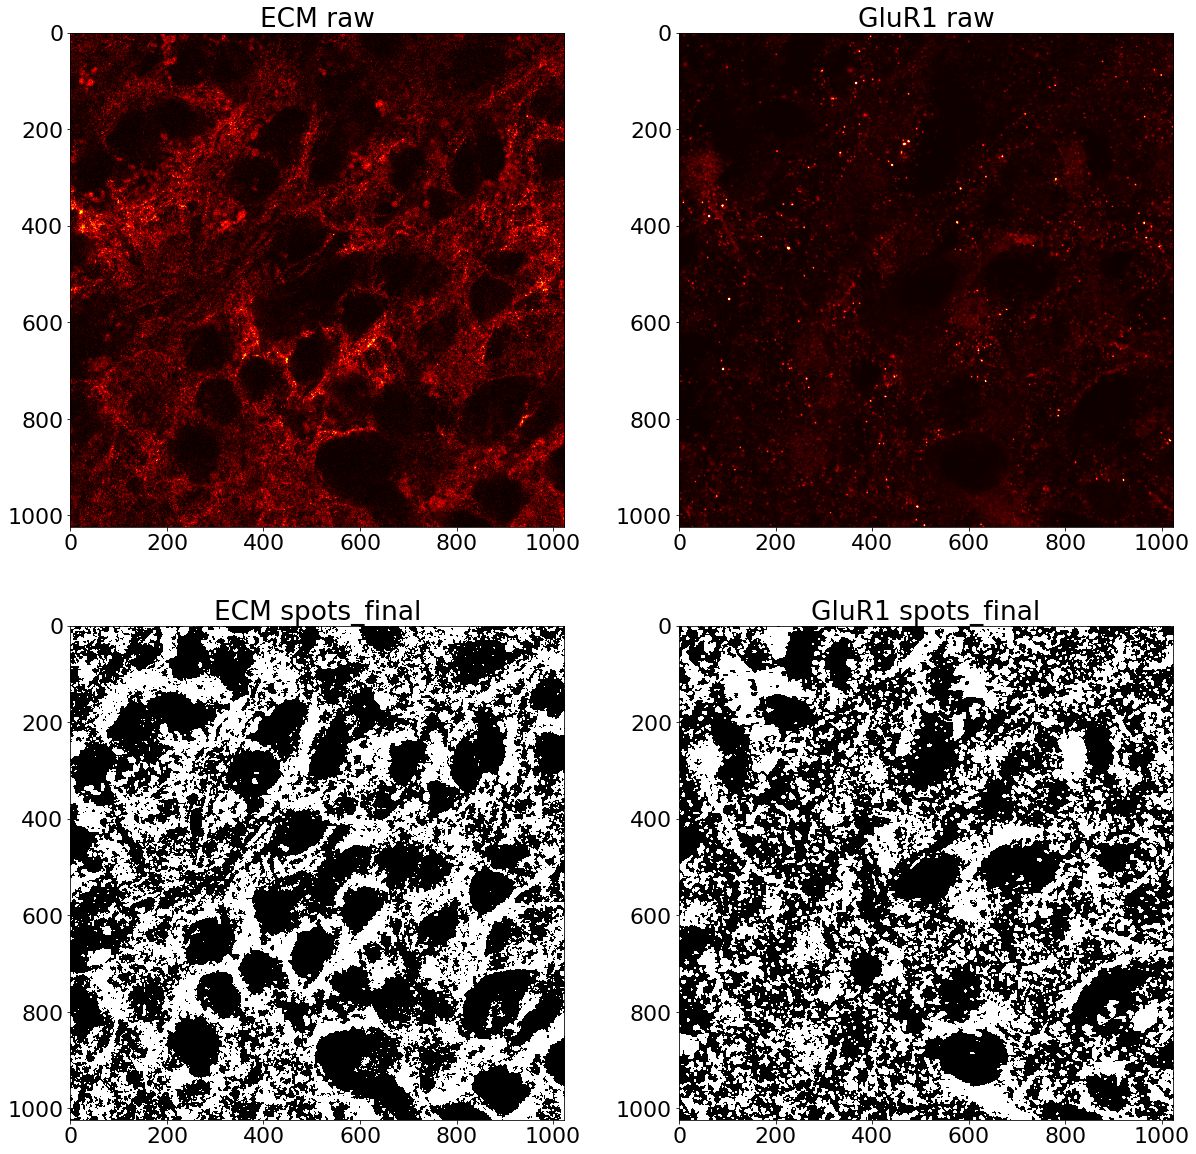

In [3]:
path=results['filename'][1]
im = pims.open(path)
ECM_image=im[ECM_channel_no-1]
GluR1_image=im[GluR1_channel_no-1]

sigmagauss_ECM=1 #Smoothing of ECM image
sigmagauss_GluR1=1 #Smoothing of GluR1 image

ECM_smooth = ndi.filters.gaussian_filter(ECM_image,sigmagauss_ECM)
GluR1_smooth = ndi.filters.gaussian_filter(GluR1_image,sigmagauss_GluR1)

#adaptive thresholding - bg found by mean filter with SE
i_ECM=151 #for SE of ECM image
i_GluR1=151 #for SE of GluR1 image

struct_ECM = (np.mgrid[:i_ECM,:i_ECM][0] - np.floor(i_ECM/2))**2 + (np.mgrid[:i_ECM,:i_ECM][1] - np.floor(i_ECM/2))**2 <= np.floor(i_ECM/2)**2
struct_GluR1 = (np.mgrid[:i_GluR1,:i_GluR1][0] - np.floor(i_GluR1/2))**2 + (np.mgrid[:i_GluR1,:i_GluR1][1] - np.floor(i_GluR1/2))**2 <= np.floor(i_GluR1/2)**2
bg_ECM = rank.mean(ECM_smooth, selem=struct_ECM)
bg_GluR1 = rank.mean(GluR1_smooth, selem=struct_GluR1)
ECM_spots = ECM_smooth >= bg_ECM
GluR1_spots = GluR1_smooth >= bg_GluR1

ECM_spots_final=ECM_spots
GluR1_spots_final=GluR1_spots

'''#improve with binary hole filling
ECM_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(ECM_spots))
GluR1_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(GluR1_spots))
#improve with binary closing
i2 = 3
struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
pad_size = i+2 #pad the spots image to avoid artifacts at the edges
padded_ECM_spots = np.pad(ECM_spots_holes_filled,pad_size,mode='reflect')
padded_GluR1_spots = np.pad(GluR1_spots_holes_filled,pad_size,mode='reflect')
ECM_spots_final = ndi.binary_closing(np.logical_not(padded_ECM_spots),structure=struct2)
GluR1_spots_final = ndi.binary_closing(np.logical_not(padded_GluR1_spots),structure=struct2)
#remove the padding from before
ECM_spots_final = ECM_spots_final[pad_size:-pad_size,pad_size:-pad_size]
GluR1_spots_final = GluR1_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''
            
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(ECM_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,2)
plt.imshow(GluR1_image,interpolation='none',cmap='hot')
plt.title('GluR1 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,3)
plt.imshow(ECM_spots_final,cmap='gray')
plt.title('ECM spots_final')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,4)
plt.imshow(GluR1_spots_final,cmap='gray')
plt.title('GluR1 spots_final')
ax=plt.gca()
ax.grid(color='none')

#### After optimizing, run below to make segmentation masks for all images

In [4]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    ECM_image=im[ECM_channel_no-1]
    GluR1_image=im[GluR1_channel_no-1]

    ECM_smooth = ndi.filters.gaussian_filter(ECM_image,sigmagauss_ECM)
    GluR1_smooth = ndi.filters.gaussian_filter(GluR1_image,sigmagauss_GluR1)

    struct_ECM = (np.mgrid[:i_ECM,:i_ECM][0] - np.floor(i_ECM/2))**2 + (np.mgrid[:i_ECM,:i_ECM][1] - np.floor(i_ECM/2))**2 <= np.floor(i_ECM/2)**2
    struct_GluR1 = (np.mgrid[:i_GluR1,:i_GluR1][0] - np.floor(i_GluR1/2))**2 + (np.mgrid[:i_GluR1,:i_GluR1][1] - np.floor(i_GluR1/2))**2 <= np.floor(i_GluR1/2)**2
    bg_ECM = rank.mean(ECM_smooth, selem=struct_ECM)
    bg_GluR1 = rank.mean(GluR1_smooth, selem=struct_GluR1)
    ECM_spots = ECM_smooth >= bg_ECM
    GluR1_spots = GluR1_smooth >= bg_GluR1

    ECM_spots_final=ECM_spots
    GluR1_spots_final=GluR1_spots

    '''
    #improve with binary hole filling
    ECM_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(ECM_spots))
    GluR1_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(GluR1_spots))
    #improve with binary closing
    i2 = 3
    struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
    pad_size = i+2 #pad the spots image to avoid artifacts at the edges
    padded_ECM_spots = np.pad(ECM_spots_holes_filled,pad_size,mode='reflect')
    padded_GluR1_spots = np.pad(GluR1_spots_holes_filled,pad_size,mode='reflect')
    ECM_spots_final = ndi.binary_closing(np.logical_not(padded_ECM_spots),structure=struct2)
    GluR1_spots_final = ndi.binary_closing(np.logical_not(padded_GluR1_spots),structure=struct2)
    #remove the padding from before
    ECM_spots_final = ECM_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    GluR1_spots_final = GluR1_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''

    results["ECM colour - spots mask"].append(ECM_spots_final)
    results["GluR1 colour - spots mask"].append(GluR1_spots_final)

Total number of images: 189
Calculating image no 0


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


Calculating image no 1
Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7
Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
C

#### Verify the segmentation (look at a random subset of raw images and their masks)

In [ ]:
for i 
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(ECM_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,2)
plt.imshow(GluR1_image,interpolation='none',cmap='hot')
plt.title('GluR1 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,3)
plt.imshow(ECM_spots_final,cmap='gray')
plt.title('ECM spots_final')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,4)
plt.imshow(GluR1_spots_final,cmap='gray')
plt.title('GluR1 spots_final')
ax=plt.gca()
ax.grid(color='none')

### Batch analyse images, after creating the segmentation masks

In [5]:
print('Total number of images: ' + str(len(results['filename'])))
for i in range(0,len(results["filename"])):    
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    ECM_image=im[ECM_channel_no-1]
    GluR1_image=im[GluR1_channel_no-1]
    #read spots masks
    ECM_spots=results["ECM colour - spots mask"][i]
    GluR1_spots=results["GluR1 colour - spots mask"][i]
    #label the spots
    spots_ECM_labels,_ = ndi.label(ECM_spots)
    spots_GluR1_labels,_ = ndi.label(GluR1_spots)
    #calcuGluR1 results
    ECM_spots_intensities=np.zeros((len(np.unique(spots_ECM_labels)),1))
    ECM_spots_areas=np.zeros((len(np.unique(spots_ECM_labels)),1))
    ECM_spots_intensities_maskedbyGluR1=np.zeros((len(np.unique(spots_GluR1_labels)),1))
    GluR1_spots_intensities=np.zeros((len(np.unique(spots_GluR1_labels)),1))
    GluR1_spots_areas=np.zeros((len(np.unique(spots_GluR1_labels)),1))

    for spotno in np.unique(spots_ECM_labels)[1:]:
        ECM_spots_mask = spots_ECM_labels==spotno
        ECM_spots_intensities[(spotno)]=np.mean(ECM_image[ECM_spots_mask])
        ECM_spots_areas[spotno]=np.sum(ECM_spots_mask)
    for spotnol in np.unique(spots_GluR1_labels)[1:]:
        GluR1_spots_mask= spots_GluR1_labels==spotnol
        GluR1_spots_intensities[spotnol]=np.mean(GluR1_image[GluR1_spots_mask])
        GluR1_spots_areas[spotnol]=np.sum(GluR1_spots_mask)
        ECM_spots_intensities_maskedbyGluR1=np.mean(ECM_image[GluR1_spots_mask])
        ECM_spots_intensities_notGluR1=np.mean(ECM_image[np.invert(GluR1_spots_mask)])

    #the following results are calcuGluR1d on the raw data

    #results based on spot segmentation    
    results["ECM colour - Mean intensity of spots"].append(np.mean(ECM_spots_intensities))
    results["GluR1 colour - Mean intensity of spots"].append(np.mean(GluR1_spots_intensities))
    results["ECM colour - Total no. of spots in FOV"].append(len(ECM_spots_intensities))
    results["GluR1 colour - Total no. of spots in FOV"].append(len(GluR1_spots_intensities))
    results["ECM colour - Mean spot area [nm]"].append(np.mean(ECM_spots_areas))
    results["GluR1 colour - Mean spot area [nm]"].append(np.mean(GluR1_spots_areas))
    results["ECM colour - Mean intensity, masked by GluR1 spots"].append(np.mean(ECM_spots_intensities_maskedbyGluR1))
    results["ECM colour - Mean intensity, outside of GluR1 spots"].append(np.mean(ECM_spots_intensities_notGluR1))


    #global results
    results["ECM colour - Raw mean intensity"].append(np.mean(ECM_image))
    results["GluR1 colour - Raw mean intensity"].append(np.mean(GluR1_image))
    results["Mean correlation coefficient ECM/GluR1"].append(corr2(ECM_image,GluR1_image))
    results["Mean colour bias of a pixel (ECM=-1<x<1=GluR1)"].append(np.mean(np.divide([GluR1_image-ECM_image],[GluR1_image+ECM_image])))

Total number of images: 189
Calculating image no 0


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)
/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in true_divide


Calculating image no 1
Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7
Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
C

### Make a clean figure of an experimental condition, with merged image and scalebar

107


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


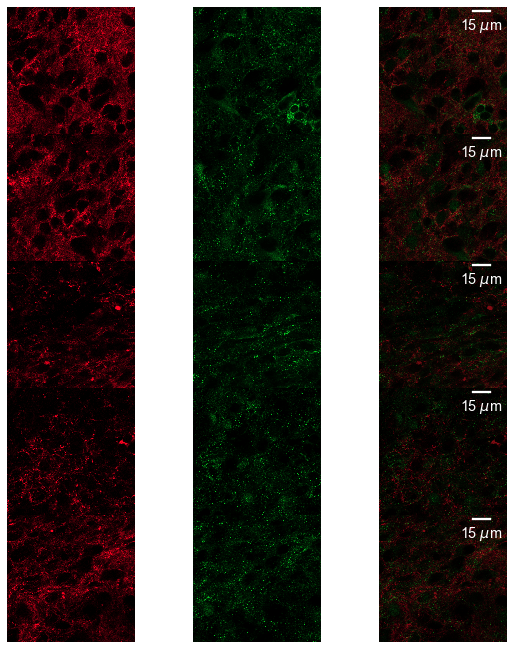

In [31]:
experimental_condition_to_display='Ctrl' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,250))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        path=results['filename'][i]
        im = pims.open(path)
        ECM_image=im[ECM_channel_no-1]
        GluR1_image=im[GluR1_channel_no-1]
       
        #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
        ECM_smoothed=ndi.filters.median_filter(ECM_image,medfiltarray)
        v_min1, v_max1 = np.percentile(ECM_smoothed, (0.2, 99.8))
        ECM_smoothed_adjusted=exposure.rescale_intensity(ECM_smoothed, in_range=(v_min1, v_max1))
        GluR1_smoothed=ndi.filters.median_filter(GluR1_image,medfiltarray)
        v_min2, v_max2 = np.percentile(GluR1_smoothed, (0.2, 99.8))
        GluR1_smoothed_adjusted=exposure.rescale_intensity(GluR1_smoothed, in_range=(v_min2, v_max2))

        #make ECM image red and GluR1 image green
        greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
        redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

        normECM = ECM_smoothed_adjusted.astype(np.float32) # convert to float
        normECM -= normECM.min() # ensure the minimal value is 0.0
        normECM /= normECM.max() # maximum value in image is now 1.0
        normGluR1 = GluR1_smoothed_adjusted.astype(np.float32) # convert to float
        normGluR1 -= normGluR1.min() # ensure the minimal value is 0.0
        normGluR1 /= normGluR1.max() # maximum value in image is now 1.0

        GluR1_ingreen=greencmap(normGluR1)
        ECM_inred=redcmap(normECM)

        #make composite with a scalebar
        comp=Image.blend(toimage(ECM_inred),toimage(GluR1_ingreen),0.5)
        micronsperpixel=0.0962
        scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,box_color='none') # 1 pixel = 0.2 meter

        fig.add_subplot(no_of_ims_in_condition,3,counter)
        plt.imshow(ECM_inred,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
        plt.imshow(GluR1_ingreen,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
        plt.imshow(comp)
        plt.gca().add_artist(scalebar)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        counter=counter+3

plt.subplots_adjust(wspace=0, hspace=0)

### Plots

In [6]:
df=pd.DataFrame(results)

0.0011556046842259595


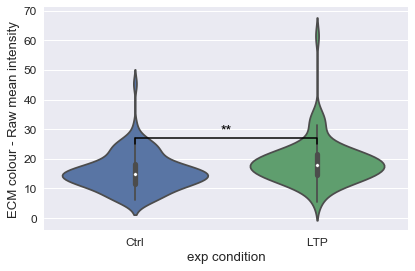

0.9407282502390153


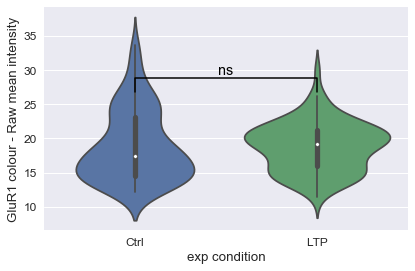

0.0008446754892806188


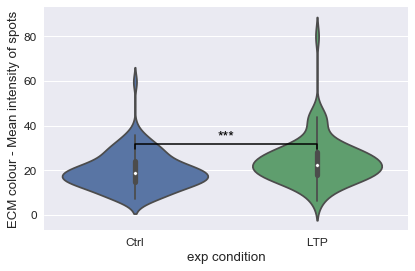

0.7788184366828157


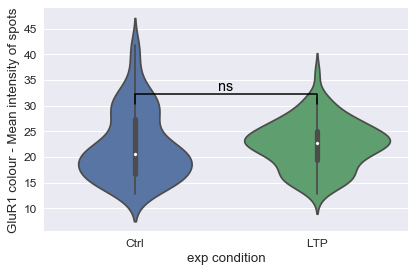

4.9745148633084396e-05


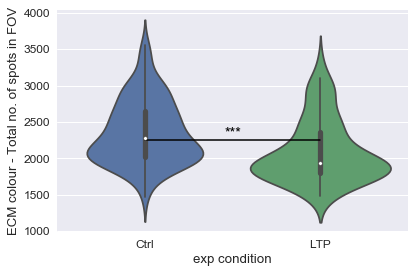

0.16852221653957616


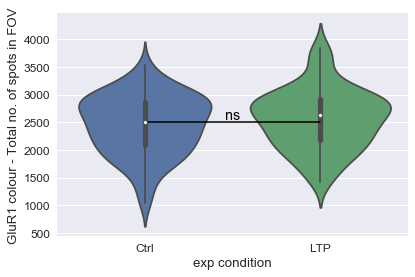

0.003445176163890894


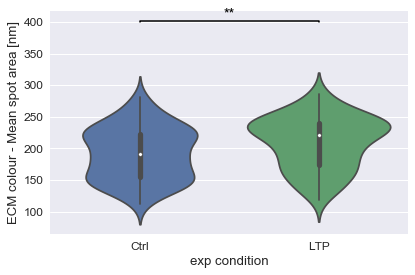

0.07221662500422026


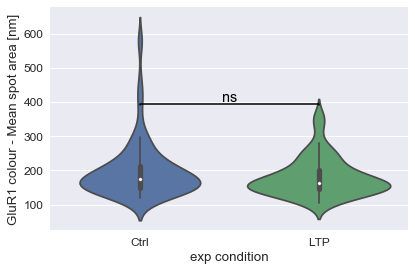

0.9153003022561139


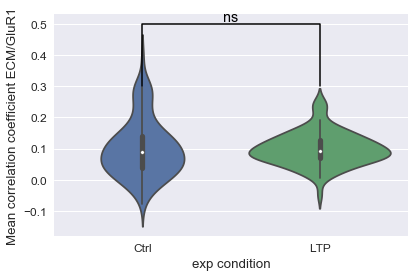

0.7136428607980669


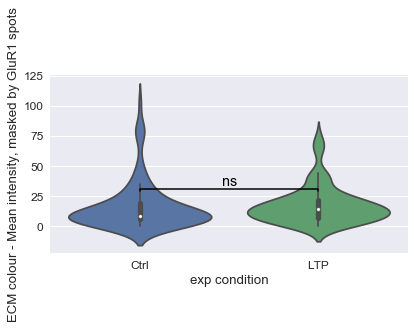

0.0011555854813660722


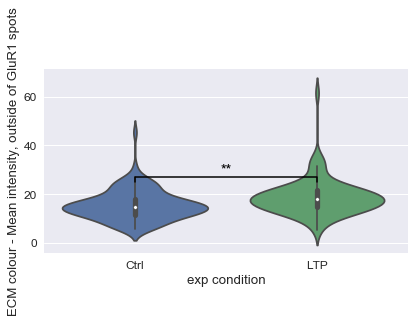

In [9]:
#statistics with scipy, plots with seaborn
sns.set(font_scale=1.2)

#raw mean intensity ECM
ECMrawint_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Raw mean intensity']
ECMrawint_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(ECMrawint_Ctrl, ECMrawint_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Raw mean intensity', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity GluR1
GluR1rawint_Ctrl = df[df['exp condition'] == 'Ctrl']['GluR1 colour - Raw mean intensity']
GluR1rawint_LTP = df[df['exp condition'] == 'LTP']['GluR1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(GluR1rawint_Ctrl, GluR1rawint_LTP)
print(pval)
sns.factorplot(kind='violin', y='GluR1 colour - Raw mean intensity', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['GluR1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity ECM spots
ECMspotint_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Mean intensity of spots']
ECMspotint_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(ECMspotint_Ctrl, ECMspotint_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Mean intensity of spots', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity GluR1 spots
GluR1spotint_Ctrl = df[df['exp condition'] == 'Ctrl']['GluR1 colour - Mean intensity of spots']
GluR1spotint_LTP = df[df['exp condition'] == 'LTP']['GluR1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(GluR1spotint_Ctrl, GluR1spotint_LTP)
print(pval)
sns.factorplot(kind='violin', y='GluR1 colour - Mean intensity of spots', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['GluR1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of ECM spots in FOV
ECMspotno_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Total no. of spots in FOV']
ECMspotno_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(ECMspotno_Ctrl, ECMspotno_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Total no. of spots in FOV', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Glur1 spots in FOV
GluR1spotno_Ctrl = df[df['exp condition'] == 'Ctrl']['GluR1 colour - Total no. of spots in FOV']
GluR1spotno_LTP = df[df['exp condition'] == 'LTP']['GluR1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(GluR1spotno_Ctrl, GluR1spotno_LTP)
print(pval)
sns.factorplot(kind='violin', y='GluR1 colour - Total no. of spots in FOV', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['GluR1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Spot Area of ECM 
ECMspotarea_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Mean spot area [nm]']
ECMspotarea_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(ECMspotarea_Ctrl, ECMspotarea_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Mean spot area [nm]', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#GluR1 spot area
GluR1spotarea_Ctrl = df[df['exp condition'] == 'Ctrl']['GluR1 colour - Mean spot area [nm]']
GluR1spotarea_LTP = df[df['exp condition'] == 'LTP']['GluR1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(GluR1spotarea_Ctrl, GluR1spotarea_LTP)
print(pval)
sns.factorplot(kind='violin', y='GluR1 colour - Mean spot area [nm]', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['GluR1 colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Corrcoeff ECM GluR1
Corrcoeff_Ctrl = df[df['exp condition'] == 'Ctrl']['Mean correlation coefficient ECM/GluR1']
Corrcoeff_LTP = df[df['exp condition'] == 'LTP']['Mean correlation coefficient ECM/GluR1']
[stat,pval]=stats.ttest_ind(Corrcoeff_Ctrl, Corrcoeff_LTP)
print(pval)
sns.factorplot(kind='violin', y='Mean correlation coefficient ECM/GluR1', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Mean correlation coefficient ECM/GluR1'].mean()+0.2 , 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#ECM intensity, masked by glur1
ECMsynapsesint_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Mean intensity, masked by GluR1 spots']
ECMsynapsesint_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Mean intensity, masked by GluR1 spots']
[stat,pval]=stats.ttest_ind(ECMsynapsesint_Ctrl, ECMsynapsesint_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Mean intensity, masked by GluR1 spots', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Mean intensity, masked by GluR1 spots'].mean() + 12, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#ECM intensity, not masked by glur1
ECMnotsynapsesint_Ctrl = df[df['exp condition'] == 'Ctrl']['ECM colour - Mean intensity, outside of GluR1 spots']
ECMnotsynapsesint_LTP = df[df['exp condition'] == 'LTP']['ECM colour - Mean intensity, outside of GluR1 spots']
[stat,pval]=stats.ttest_ind(ECMnotsynapsesint_Ctrl, ECMnotsynapsesint_LTP)
print(pval)
sns.factorplot(kind='violin', y='ECM colour - Mean intensity, outside of GluR1 spots', x='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['ECM colour - Mean intensity, outside of GluR1 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()


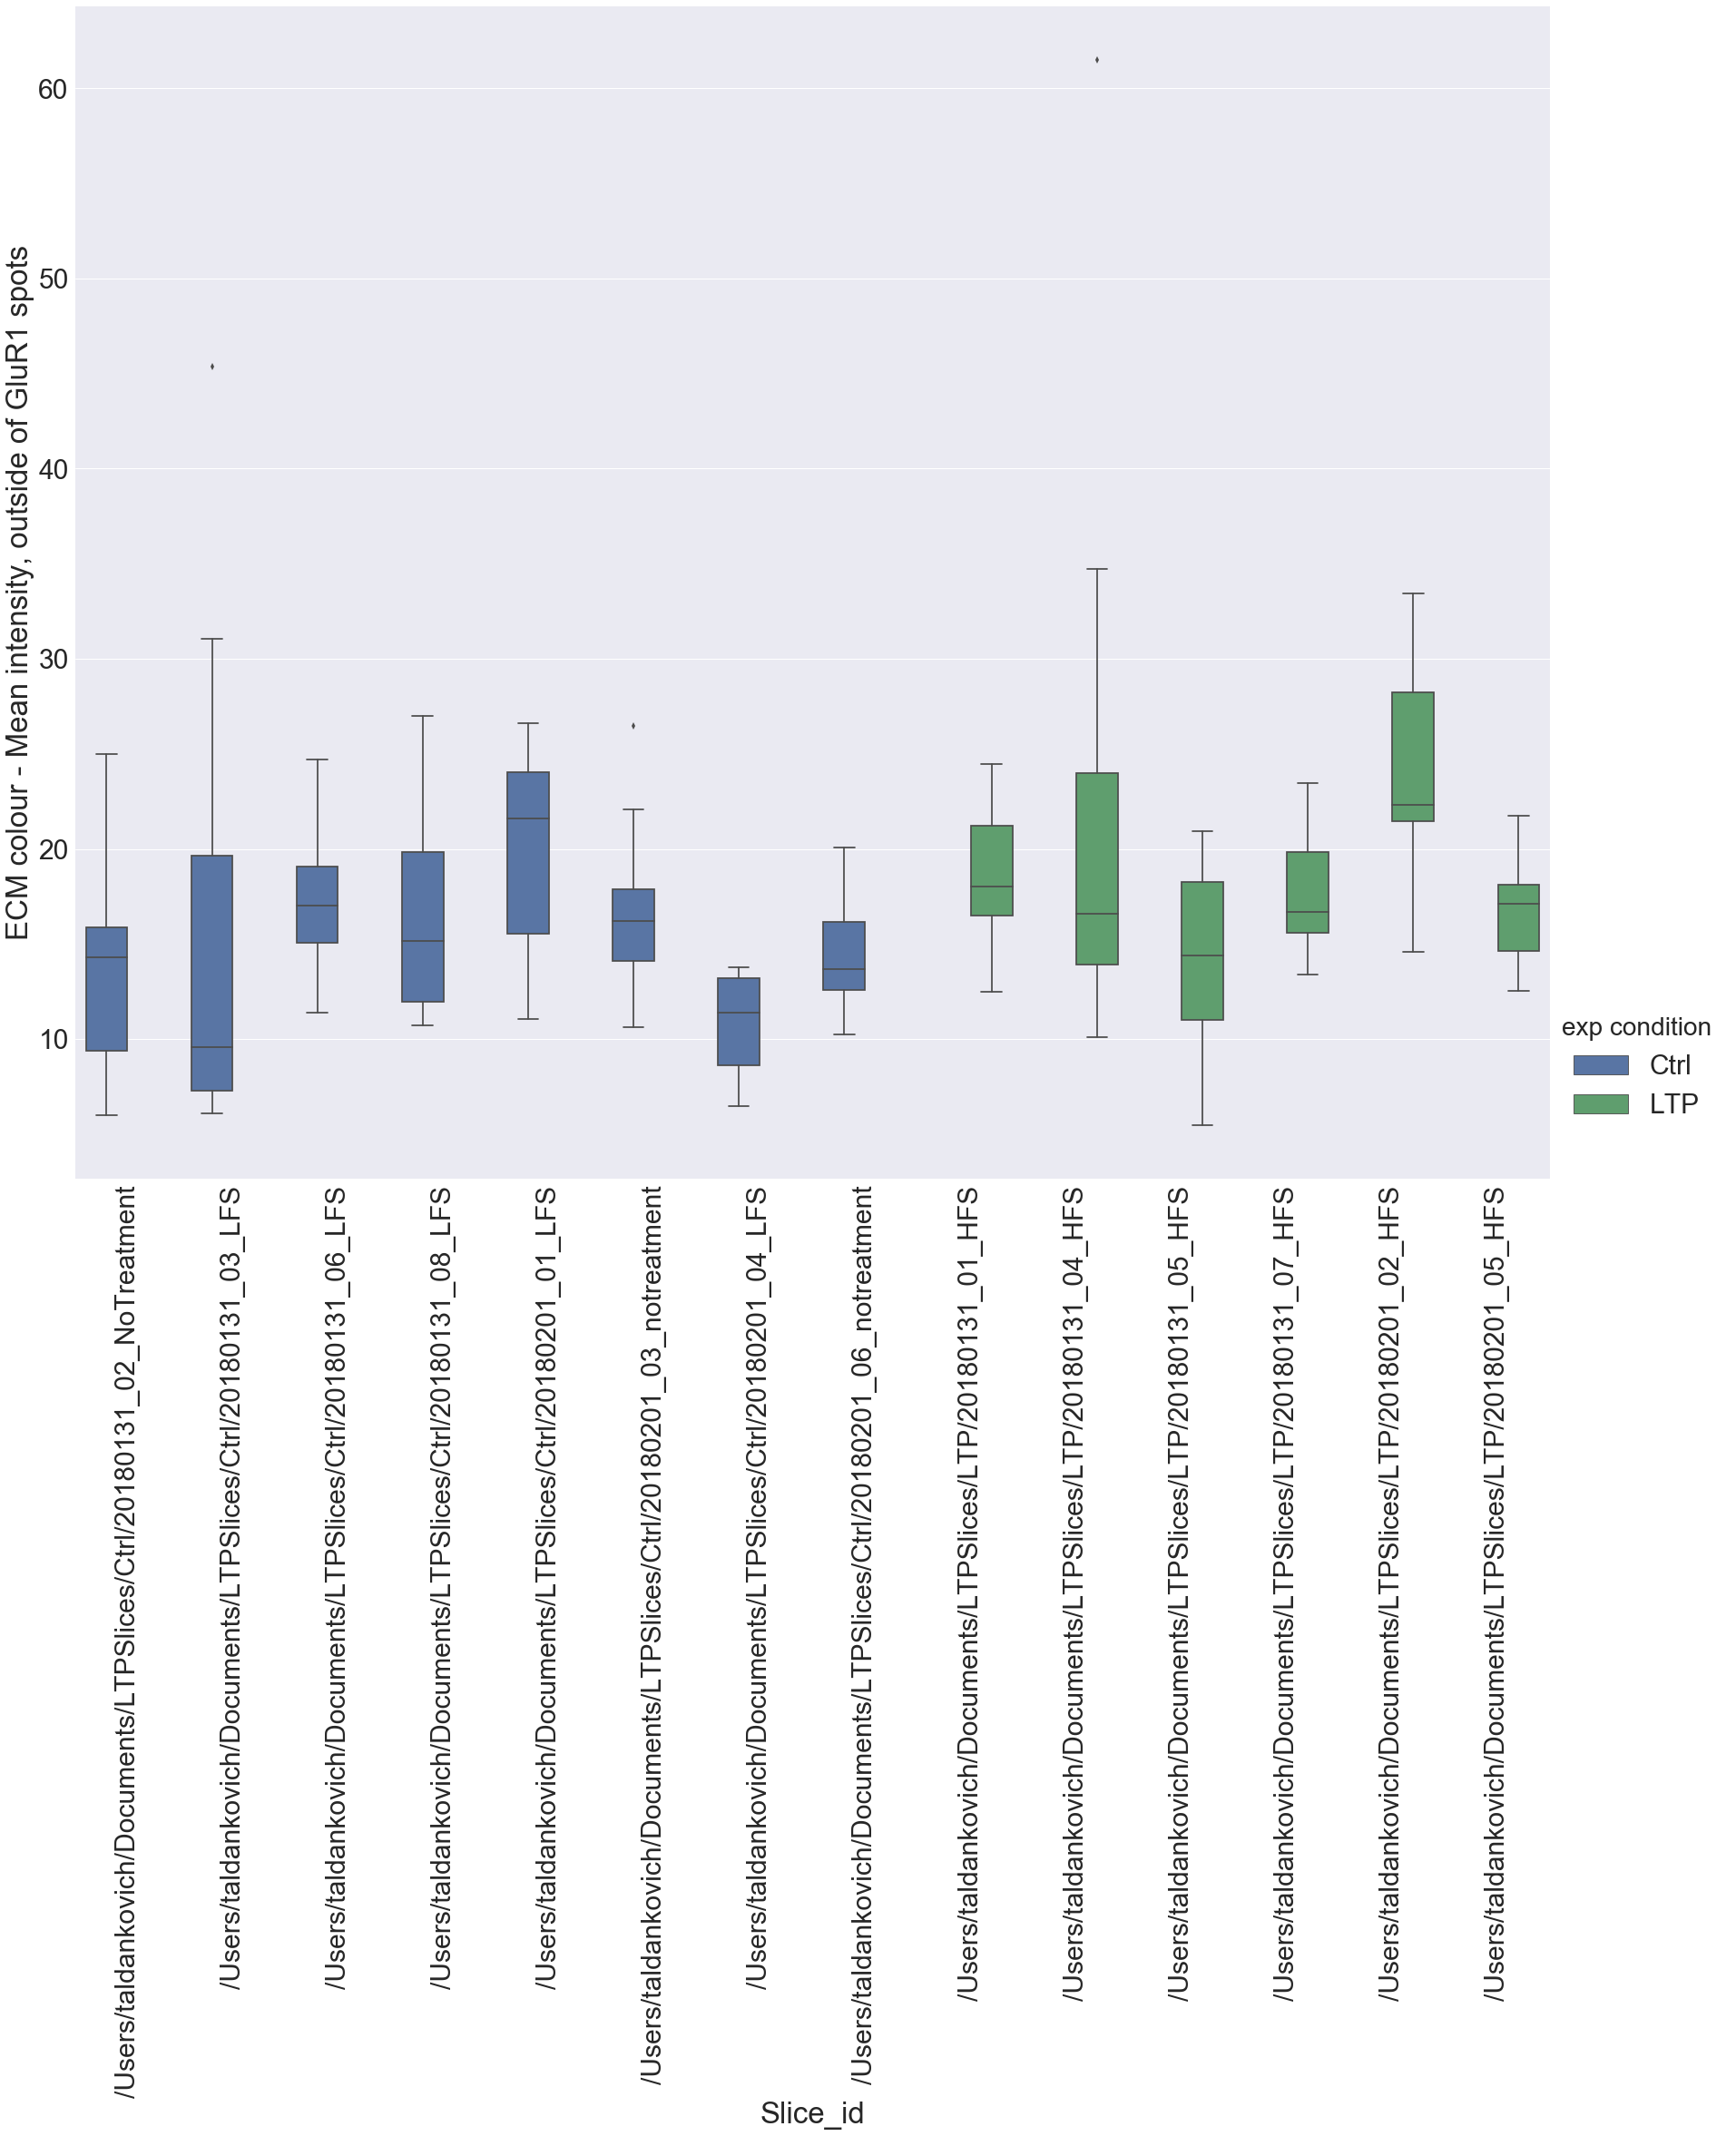

In [10]:
sns.set(font_scale=3)

g=sns.factorplot(kind='box', y='ECM colour - Mean intensity, outside of GluR1 spots', x='Slice_id',hue='exp condition',data=df, size=20, aspect=1.5, legend_out=True) 
#g.set(font_scale=1)
g.set_xticklabels(rotation=90)
